In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

In [4]:
# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

In [5]:
# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

# XGboost

In [6]:
# 定义XGBoost模型，提前设置early_stopping_rounds
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=10)

# 定義 XGBoost 模型，並設置基本參數與早停條件
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 設置目標函數為平方誤差
    random_state=123456,               # 設定隨機種子以確保結果可重現 42
    early_stopping_rounds=10       # 如果驗證集指標在 10 輪內無改善則提前停止
)

# 定義超參數搜索的候選值範圍
param_dist = {
    'max_depth': [3, 6, 10, 12],          # 樹的最大深度，控制模型的複雜度
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # 每次迭代的步伐大小
    'n_estimators': [50, 100, 200, 300],  # 樹的數量
    'subsample': [0.7, 0.8, 0.9, 1.0],    # 每棵樹隨機採樣的比例
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # 每棵樹使用的特徵比例
    'gamma': [0, 0.1, 0.2, 0.3],          # 控制節點分裂的最小增益
    'reg_alpha': [0, 0.01, 0.1, 1],       # L1 正則化強度
    'reg_lambda': [0, 0.01, 0.1, 1],      # L2 正則化強度
    'min_child_weight': [1, 3, 5],        # 每個葉子節點的最小樣本權重
}

# 使用隨機搜尋進行超參數調整
random_search = RandomizedSearchCV(
    estimator=xgb_model,                 # 基礎模型為 XGBoost
    param_distributions=param_dist,      # 定義超參數搜索空間
    n_iter=100,                          # 搜索 100 次
    cv=5,                                # 使用 5 折交叉驗證
    scoring='neg_mean_absolute_error',   # 評估指標為負的平均絕對誤差
    n_jobs=-1,                           # 使用所有可用 CPU 加速計算
    random_state=42                      # 設定隨機種子以確保結果可重現
)

# 訓練模型並進行超參數搜索
random_search.fit(
    X_train_reguli, y_train_reguli,                    # 訓練數據
    eval_set=[(X_test_reguli, y_test_reguli)],         # 提供測試集進行早停監控
    verbose=True                         # 在訓練過程中輸出詳細信息
)

# 提取經過超參數調整後的最佳模型 (判斷標準MAE)
best_xgb_model = random_search.best_estimator_
# 顯示最佳超參數
print("參數之選擇:", random_search.best_params_)


# # 預測訓練集結果
# y_pred_train = best_xgb_model.predict(X_train)
# # 預測測試集結果
# y_pred_test = best_xgb_model.predict(X_test)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli)*ohca_reguli_inverse
y_train = y_train_reguli*ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli)*ohca_reguli_inverse
y_test = y_test_reguli*ohca_reguli_inverse

[0]	validation_0-rmse:0.24230
[1]	validation_0-rmse:0.22471
[2]	validation_0-rmse:0.20415
[3]	validation_0-rmse:0.17930
[4]	validation_0-rmse:0.16875
[5]	validation_0-rmse:0.16350
[6]	validation_0-rmse:0.16094
[7]	validation_0-rmse:0.15459
[8]	validation_0-rmse:0.15079
[9]	validation_0-rmse:0.14900
[10]	validation_0-rmse:0.14368
[11]	validation_0-rmse:0.14263
[12]	validation_0-rmse:0.14197
[13]	validation_0-rmse:0.13930
[14]	validation_0-rmse:0.13911
[15]	validation_0-rmse:0.14062
[16]	validation_0-rmse:0.13964
[17]	validation_0-rmse:0.13368
[18]	validation_0-rmse:0.13112
[19]	validation_0-rmse:0.13139
[20]	validation_0-rmse:0.13253
[21]	validation_0-rmse:0.13256
[22]	validation_0-rmse:0.13272
[23]	validation_0-rmse:0.13164
[24]	validation_0-rmse:0.13308
[25]	validation_0-rmse:0.13327
[26]	validation_0-rmse:0.13237
[27]	validation_0-rmse:0.13219
[28]	validation_0-rmse:0.13240
參數之選擇: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_dep

In [7]:
#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

MAE of train set=  1.3626836248005865
R² of train set=  0.9372898097279823
MAE of test set=  6.237794437170762
R² of test set=  0.7051566952547825


# XGboost LIME

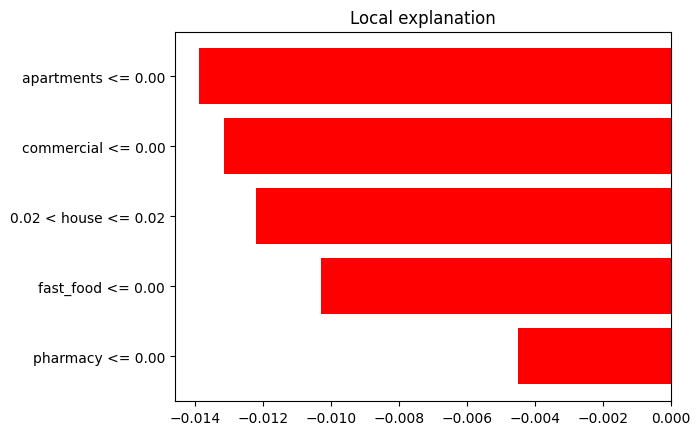

In [8]:
import lime
import lime.lime_tabular

test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_reguli),
    feature_names=feature_names,
    mode='regression',
    kernel_width=0.75,         # 调整邻近样本的相似性范围
    discretize_continuous=True, # 启用连续特征的离散化
    discretizer='decile',     # 使用四分位数离散化
    random_state=42,            # 设置随机种子
  # 使用Lasso路径进行特征选择
)

# 選擇一個測試樣本進行解釋
idx = 36  # 可以修改 idx 來選擇不同樣本
exp = explainer.explain_instance(X_test_reguli[idx], best_xgb_model.predict, num_features=5)

# 繪製 LIME 解釋圖
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()
plt.show()

In [ ]:
exp = explainer.explain_instance(X_test_reguli[idx], best_xgb_model.predict, num_features=5)

# 提取貢獻值
contributions_relu = exp.as_list()
contribution_relu_dict = {
re.sub(r'[^a-zA-Z_]', '', feature): value for feature, value in contributions_relu} # 只保留英文字母和底線

contribution_dict = {key: value *ohca_reguli_inverse  for key, value in contribution_relu_dict.items()}
contribution_dict

{'cabin': 0.0003155077368099784,
 'commercial': 0.0003052614220760413,
 'church': 0.0002987362564241437,
 'apartments': 0.000279073750233683,
 'house': 0.0002739464082321133}

In [9]:
from tqdm import tqdm  # 用於顯示進度條
import re  # 導入正則表達式模組
import seaborn as sns

# 初始化一個空的 DataFrame 來存儲所有樣本的貢獻值
all_contributions = []

# 對每個樣本運行 LIME 並提取貢獻值
for idx in tqdm(range(len(X_test_reguli))):  # 使用 tqdm 顯示進度
    exp = explainer.explain_instance(X_test_reguli[idx], best_xgb_model.predict, num_features=5)
    
    # 提取貢獻值
    contributions_relu = exp.as_list()
    contribution_relu_dict = {
    re.sub(r'[^a-zA-Z_]', '', feature): value for feature, value in contributions_relu} # 只保留英文字母和底線

    contribution_dict = {key: value *ohca_reguli_inverse  for key, value in contribution_relu_dict.items()}
    all_contributions.append(contribution_dict)  # 將字典添加到列表中

# 將所有樣本的貢獻值合併為一個 DataFrame
all_contributions_df = pd.DataFrame(all_contributions)

 24%|██▍       | 23/94 [00:26<01:22,  1.16s/it]c:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.68359e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.68359e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.50008e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Yuan\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.50008e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
 63%|██████▎   | 59/94 [01:17<00:

In [18]:
all_contributions_df = all_contributions_df.fillna(0)
all_contributions_df

house  apartments  commercial  fast_food  pharmacy     hotel  garage  \
0  -1.522654   -1.382716   -1.374350  -0.699206 -0.616056  0.000000     0.0   
1  -1.309877   -1.336790   -1.537223  -0.886640 -0.745204  0.000000     0.0   
2  -1.212514   -1.440037   -1.135760  -0.837960 -0.794329  0.000000     0.0   
3   0.000000   -0.678427   -1.649175  -0.516463 -0.368970 -0.684613     0.0   
4  -1.137181   -1.505980   -1.365552  -0.813121 -0.541334  0.000000     0.0   
..       ...         ...         ...        ...       ...       ...     ...   
89  0.000000    0.004810    0.006328   0.000000 -0.000196  0.000000     0.0   
90  0.000000   -0.465195   -0.760067  -0.181262 -0.146167  0.000000     0.0   
91  0.000000    0.046872    0.049185   0.000000  0.001219  0.000000     0.0   
92  0.000000   -1.119131   -0.946859  -0.540771 -0.410684  0.000000     0.0   
93  0.000302    0.000312    0.000342   0.000000  0.000010  0.000000     0.0   

    letter_box  fire_station  school  ...  internet_cafe  public_building  \
0          0.0      0.000000     0.0  ...            0.0              0.0   
1          0.0      0.000000     0.0  ...            0.0              0.0   
2          0.0      0.000000     0.0  ...            0.0              0.0   
3          0.0      0.000000     0.0  ...            0.0              0.0   
4          0.0      0.000000     0.0  ...            0.0              0.0   
..         ...           ...     ...  ...            ...              ...   
89         0.0      0.000000     0.0  ...            0.0              0.0   
90         0.0     -0.143637     0.0  ...            0.0              0.0   
91         0.0      0.000000     0.0  ...            0.0              0.0   
92         0.0      0.000000     0.0  ...            0.0              0.0   
93         0.0      0.000000     0.0  ...            0.0              0.0   

    bbq  driving_school  kindergarten  charging_station  gambling  \
0   0.0             0.0           0.0               0.0       0.0   
1   0.0             0.0           0.0               0.0       0.0   
2   0.0             0.0           0.0               0.0       0.0   
3   0.0             0.0           0.0               0.0       0.0   
4   0.0             0.0           0.0               0.0       0.0   
..  ...             ...           ...               ...       ...   
89  0.0             0.0           0.0               0.0       0.0   
90  0.0             0.0           0.0               0.0       0.0   
91  0.0             0.0           0.0               0.0       0.0   
92  0.0             0.0           0.0               0.0       0.0   
93  0.0             0.0           0.0               0.0       0.0   

    construction  drinking_water   theatre  
0       0.000000        0.000000  0.000000  
1       0.000000        0.000000  0.000000  
2       0.000000        0.000000  0.000000  
3       0.000000        0.000000  0.000000  
4       0.000000        0.000000  0.000000  
..           ...             ...       ...  
89      0.003322        0.000000  0.000000  
90      0.000000        0.000000  0.000000  
91      0.000000        0.044332  0.000000  
92      0.000000        0.000000  0.000000  
93      0.000000        0.000000  0.000355  

[94 rows x 48 columns]

In [19]:
all_contributions_df.sum()

house              -2.250644e+01
apartments         -3.384473e+01
commercial         -4.490648e+01
fast_food          -2.473950e+01
pharmacy           -1.749438e+01
hotel              -6.846132e-01
garage             -6.008892e-01
letter_box         -1.079623e+00
fire_station        8.953340e-01
school             -1.556846e+00
courthouse          7.772172e-07
parking            -2.935421e-02
public              3.615915e-03
bunker             -9.632598e-04
shed                3.232417e+00
cafe                1.517683e-01
residential        -4.764115e-01
university          1.182025e-01
roof                5.004960e-02
fountain           -1.136110e+00
static_caravan     -6.311332e-01
place_of_worship    4.967546e-01
detached            1.319067e-01
restaurant          2.729743e-02
terrace             1.474851e-04
loading_dock        2.116427e-04
bank                1.447834e-04
childcare          -1.694814e-03
car_rental          2.524912e-04
waste_basket        1.795919e-03
service   

In [20]:
# 計算每個特徵的總和貢獻值，並選取最高的前 10 名
top_10_features = all_contributions_df.sum().abs().nlargest(10).index  # 取絕對值後選取前 10 名
top_10_contributions_df = all_contributions_df[top_10_features]

# # 繪製點狀圖
# plt.figure(figsize=(10, 6))
# sns.stripplot(data=top_10_contributions_df, orient="h", palette="viridis", alpha=0.7)
# plt.title("Top 10 Features by Total Contribution (LIME)")
# plt.xlabel("Contribution Value")
# plt.ylabel("Feature")
# plt.show()

In [21]:
test_h3_l7_df_chart = test_h3_l7_df.drop('id', axis=1).drop('ohca', axis=1)

from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors

scaler = MinMaxScaler()
test_h3_l7_df_chart[test_h3_l7_df_chart.columns] = scaler.fit_transform(test_h3_l7_df_chart[test_h3_l7_df_chart.columns])

# 將 DataFrame 轉換為長格式，方便繪圖
top_10_contributions_long = top_10_contributions_df.melt(var_name='Feature', value_name='Contribution', ignore_index=False)

# 將 test_h3_l7_df 轉換為長格式
test_h3_l7_long = test_h3_l7_df_chart[top_10_features].melt(var_name='Feature', value_name='H3_L7_Value', ignore_index=False)

# 合併 test_h3_l7_df 的值到貢獻值 DataFrame 中
top_10_contributions_long = top_10_contributions_long.merge(
    test_h3_l7_long,
    on=['Feature'],  # 根據特徵名稱合併
    how='left'
)

# 確保 Feature 軸是類別變數，而非數值
feature_labels = top_10_contributions_long["Feature"].unique()  # 取得所有特徵名稱
feature_mapping = {feature: idx for idx, feature in enumerate(feature_labels)}  # 建立對應關係
top_10_contributions_long["Feature_Index"] = top_10_contributions_long["Feature"].map(feature_mapping)  # 轉換為索引


In [22]:
top_10_contributions_long

Feature  Contribution  H3_L7_Value  Feature_Index
0        commercial      -1.37435     0.000000              0
1        commercial      -1.37435     0.000000              0
2        commercial      -1.37435     0.000000              0
3        commercial      -1.37435     0.010417              0
4        commercial      -1.37435     0.000000              0
...             ...           ...          ...            ...
88355  fire_station       0.00000     0.000000              9
88356  fire_station       0.00000     0.000000              9
88357  fire_station       0.00000     0.250000              9
88358  fire_station       0.00000     0.000000              9
88359  fire_station       0.00000     0.250000              9

[88360 rows x 4 columns]

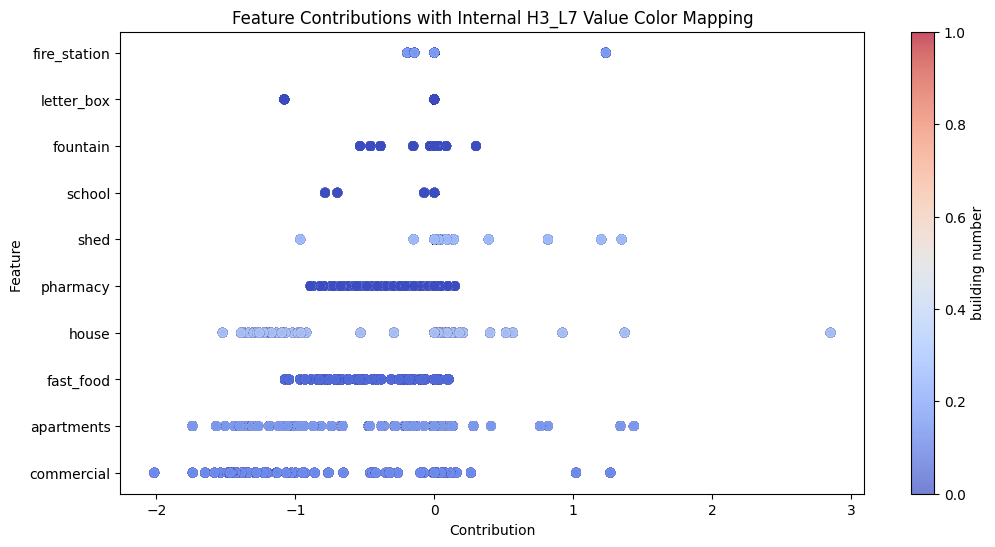

In [23]:
cmap = plt.get_cmap("coolwarm")  # 由藍到紅

# 繪製散點圖
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    np.array(top_10_contributions_long["Contribution"]),
    np.array(top_10_contributions_long["Feature_Index"]),  # 使用正確的類別索引
    c=np.array(top_10_contributions_long["H3_L7_Value"]),  # 讓顏色由 H3_L7_Value 控制
    cmap=cmap,
    alpha=0.7
)

# 設定 X 軸為 Feature 名稱
plt.yticks(ticks=np.arange(len(feature_labels)), labels=feature_labels)

# 添加顏色條
cbar = plt.colorbar(scatter)
cbar.set_label("building number")

plt.xlabel("Contribution")
plt.ylabel("Feature ")
plt.title("Feature Contributions with Internal H3_L7 Value Color Mapping")
plt.show()

In [20]:
top_10_contributions_long_zero = top_10_contributions_long[top_10_contributions_long["H3_L7_Value"] == 0]
top_10_contributions_long_num = top_10_contributions_long[top_10_contributions_long["H3_L7_Value"] != 0]

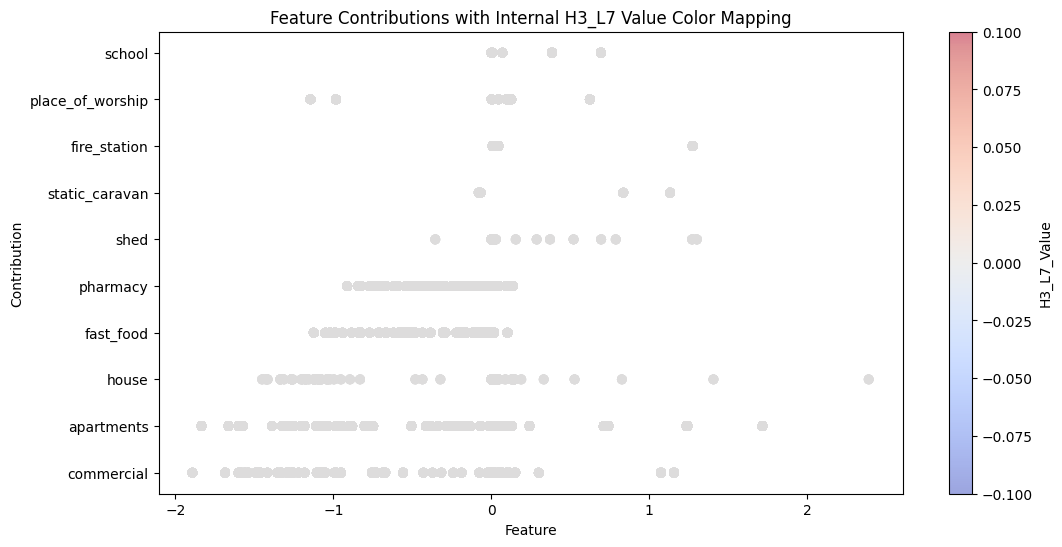

In [21]:
# 創建顏色映射 (藍到紅)
norm = mcolors.Normalize(vmin=top_10_contributions_long["H3_L7_Value"].min(), 
                         vmax=top_10_contributions_long["H3_L7_Value"].max())
cmap = plt.get_cmap("coolwarm")  # 由藍到紅

# 繪製散點圖
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    np.array(top_10_contributions_long_zero["Contribution"]),
    np.array(top_10_contributions_long_zero["Feature_Index"]),  # 使用正確的類別索引
    c=np.array(top_10_contributions_long_zero["H3_L7_Value"]),  # 讓顏色由 H3_L7_Value 控制
    cmap=cmap,
    alpha=0.5
)

# 設定 X 軸為 Feature 名稱
plt.yticks(ticks=np.arange(len(feature_labels)), labels=feature_labels)

# 添加顏色條
cbar = plt.colorbar(scatter)
cbar.set_label("H3_L7_Value")

plt.xlabel("Feature")
plt.ylabel("Contribution")
plt.title("Feature Contributions with Internal H3_L7 Value Color Mapping")
plt.show()

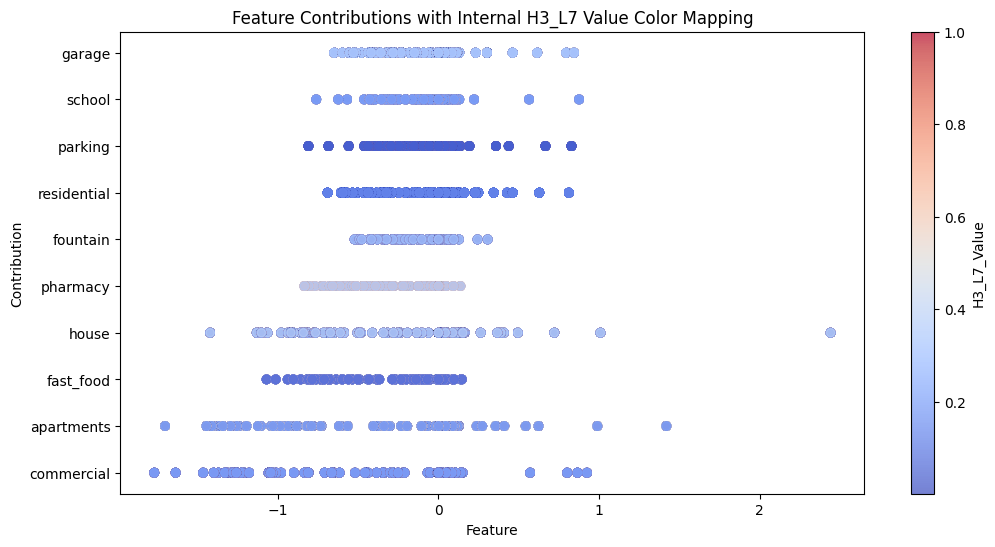

In [ ]:
# top_10_contributions_long_num = top_10_contributions_long[(top_10_contributions_long["H3_L7_Value"] >= 0.3) & (top_10_contributions_long["H3_L7_Value"] <= 0.7)]
top_10_contributions_long_num = top_10_contributions_long[(top_10_contributions_long["H3_L7_Value"] >0)]
# 創建顏色映射 (藍到紅)
norm = mcolors.Normalize(vmin=top_10_contributions_long["H3_L7_Value"].min(), 
                         vmax=top_10_contributions_long["H3_L7_Value"].max())
cmap = plt.get_cmap("coolwarm")  # 由藍到紅

# 繪製散點圖
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    np.array(top_10_contributions_long_num["Contribution"]),
    np.array(top_10_contributions_long_num["Feature_Index"]),  # 使用正確的類別索引
    c=np.array(top_10_contributions_long_num["H3_L7_Value"]),  # 讓顏色由 H3_L7_Value 控制
    cmap=cmap,
    alpha=0.7
)

# 設定 X 軸為 Feature 名稱
plt.yticks(ticks=np.arange(len(feature_labels)), labels=feature_labels)

# 添加顏色條
cbar = plt.colorbar(scatter)
cbar.set_label("H3_L7_Value")

plt.xlabel("Feature")
plt.ylabel("Contribution")
plt.title("Feature Contributions with Internal H3_L7 Value Color Mapping")
plt.show()

In [ ]:
def scatter_2d(house_type):
    # 假設 df_top_10_contributions_long 是你的 DataFrame
    # 篩選出 Feature 為 pharmacy 的數據
    pharmacy_data = top_10_contributions_long[top_10_contributions_long['Feature'] == house_type]

    # 繪製散佈圖
    plt.figure(figsize=(10, 6))
    plt.scatter(pharmacy_data['Contribution'], pharmacy_data['H3_L7_Value'], alpha=0.5)
    title = 'Scatter Plot of '+ house_type + ' Contributions vs H3_L7_Value'
    # 添加標籤和標題
    plt.xlabel('Contribution')
    plt.ylabel('H3_L7_Value')
    plt.title(title)

    # 顯示圖表
    plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # 示例浮点数据
# pharmacy_data = top_10_contributions_long[top_10_contributions_long['Feature'] == 'fire_station']
# data =  pharmacy_data[ pharmacy_data['H3_L7_Value'] > 0.8 ]['Contribution']

# # 将数据转换为 pandas Series
# series=pd.Series(data)

# # 对浮点数据进行分箱（binning）
# # 这里我们手动设置区间宽度为 1.0
# bins=np.arange(min(data), max(data) + 0.01, 0.01) # 区间从最小值到最大值，步长为 1.0
# frequency = pd.cut(series, bins=bins).value_counts().sort_index()
# # 绘制柱状图
# frequency.plot(kind='bar', color='skyblue', edgecolor='black')
# plt.show()

# # 示例浮点数据
# pharmacy_data = top_10_contributions_long[top_10_contributions_long['Feature'] == 'fire_station']
# data =  pharmacy_data[ pharmacy_data['H3_L7_Value'] < 0.1 ]['Contribution']
# # 将数据转换为 pandas Series
# series=pd.Series(data)

# # 对浮点数据进行分箱（binning）
# # 这里我们手动设置区间宽度为 1.0
# bins=np.arange(min(data), max(data) + 0.01, 0.01) # 区间从最小值到最大值，步长为 1.0
# frequency = pd.cut(series, bins=bins).value_counts().sort_index()
# # 绘制柱状图
# frequency.plot(kind='bar', color='skyblue', edgecolor='black')
# plt.show()

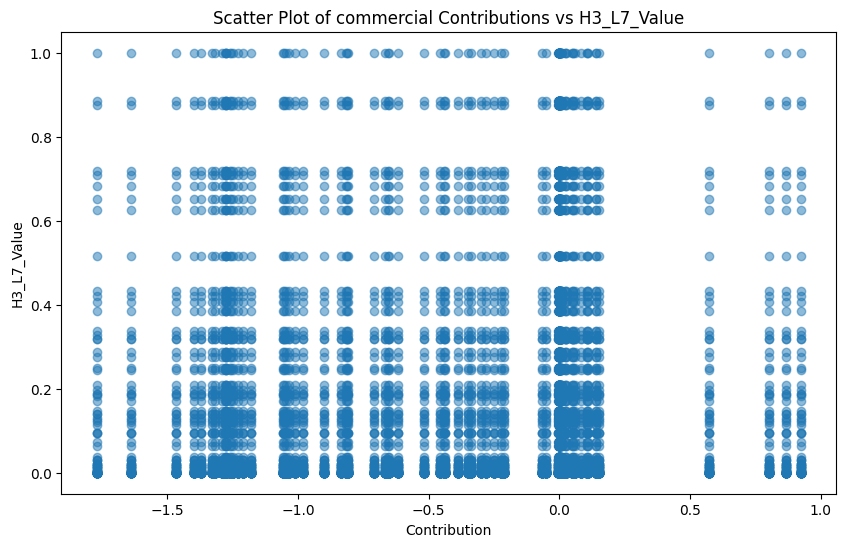

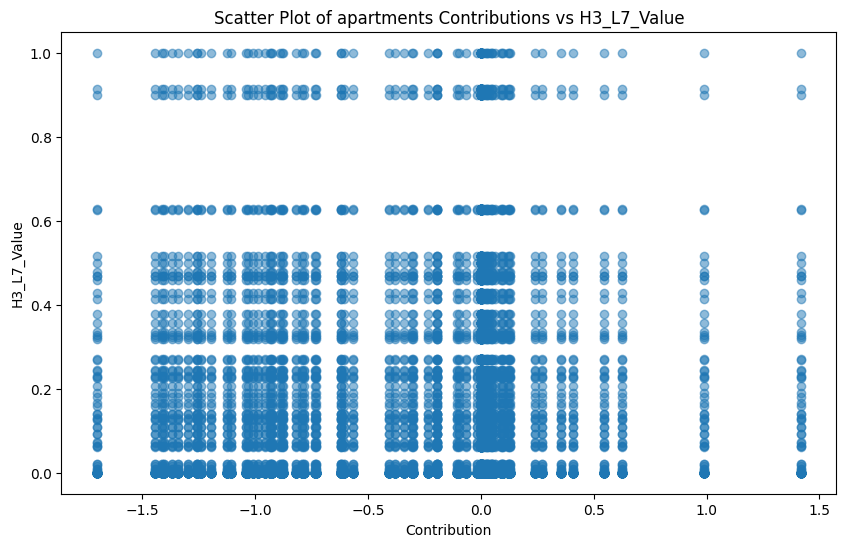

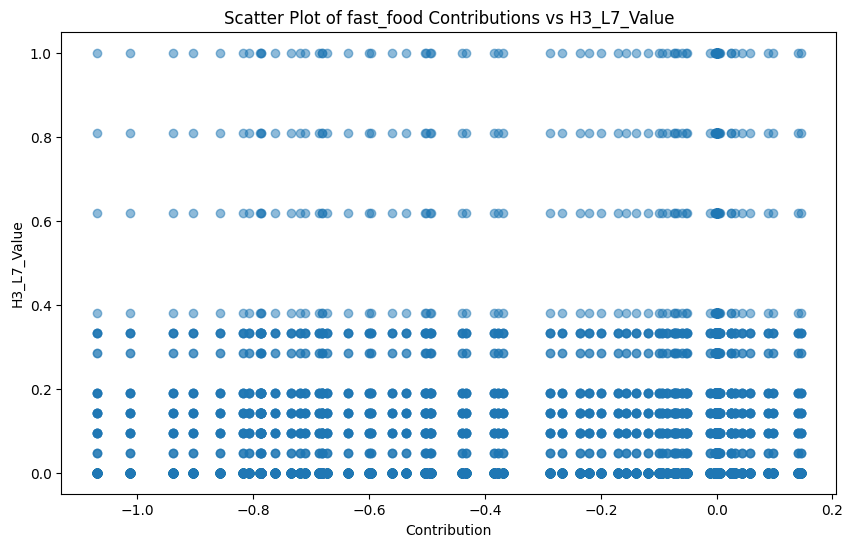

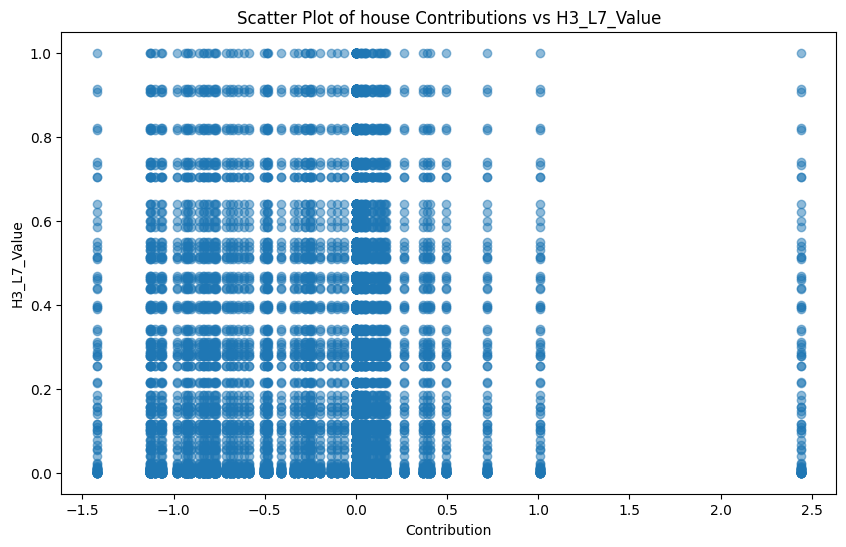

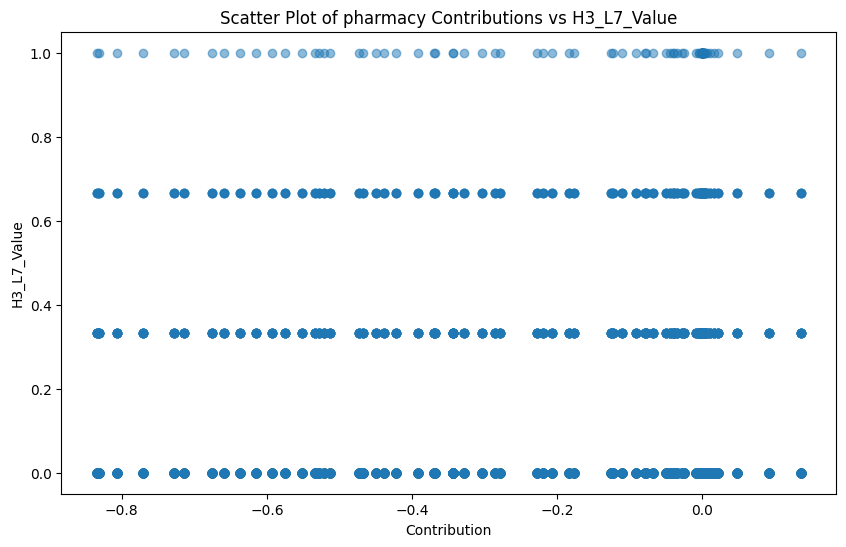

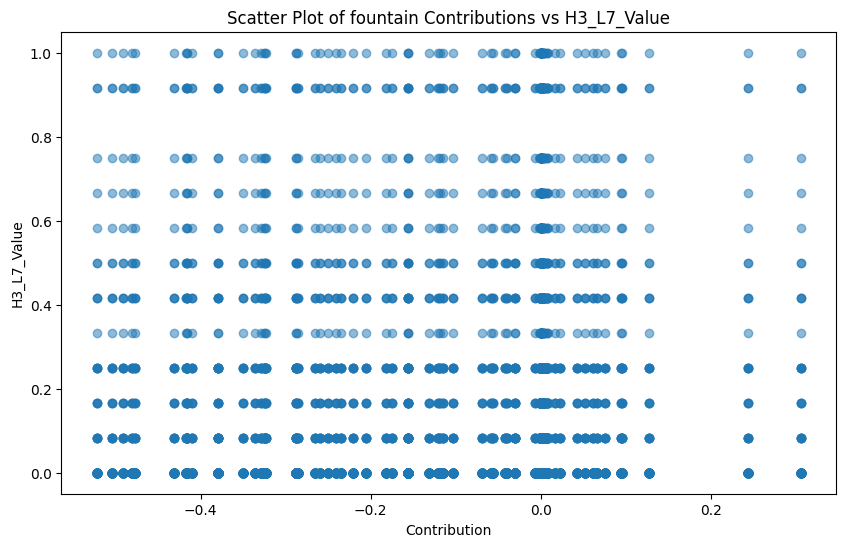

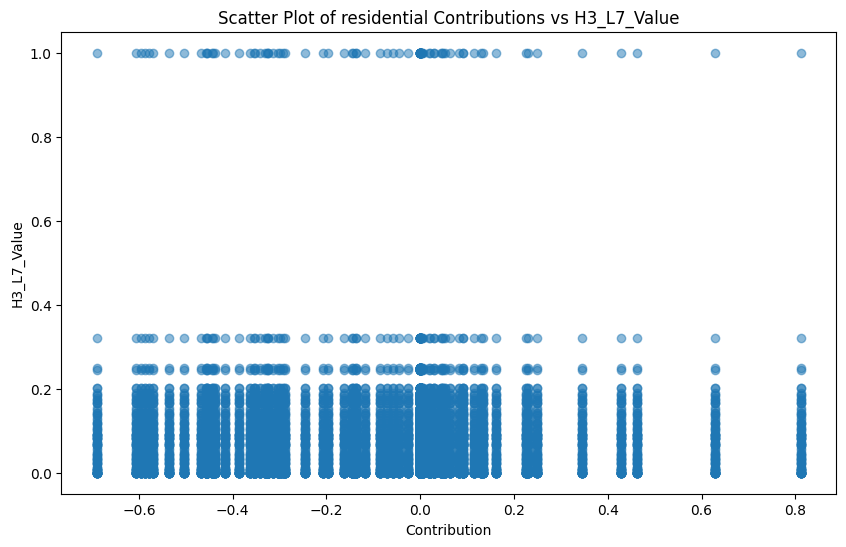

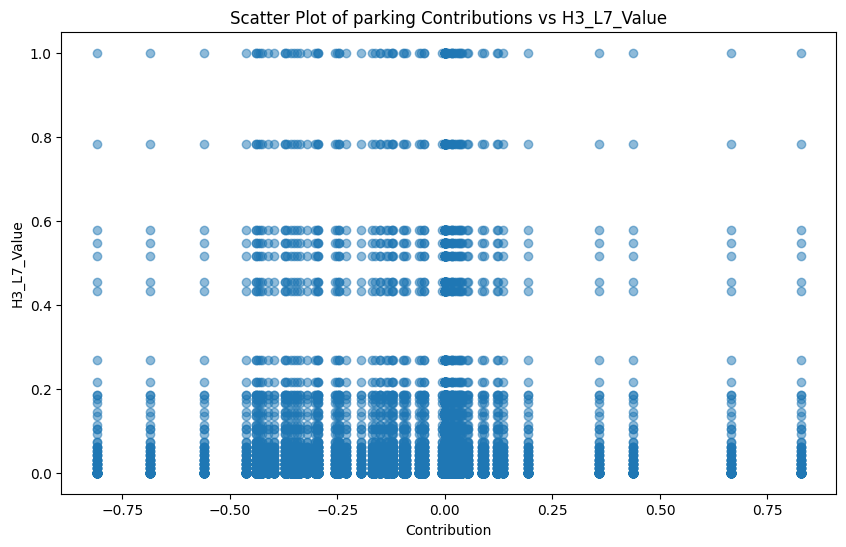

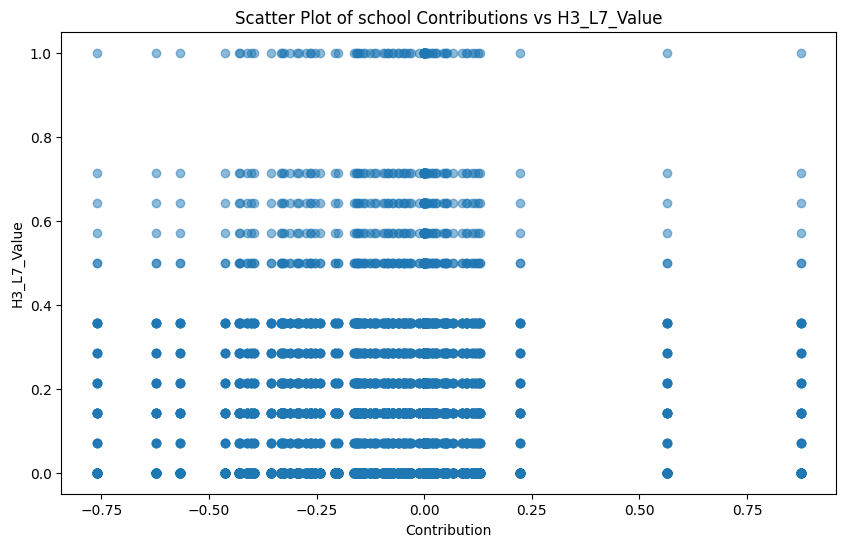

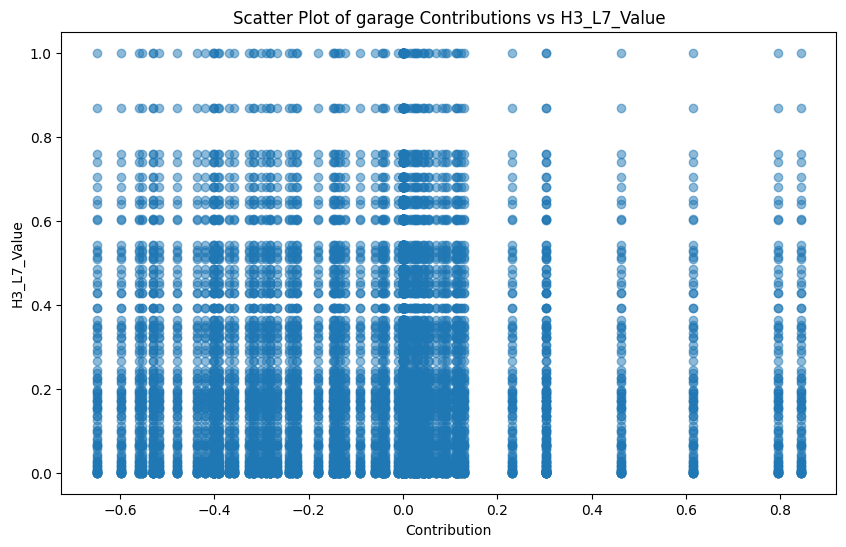

In [ ]:
house_types = top_10_contributions_long['Feature'].unique()
for house_type in house_types:
    scatter_2d(house_type)

c:\Users\Yuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Yuan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


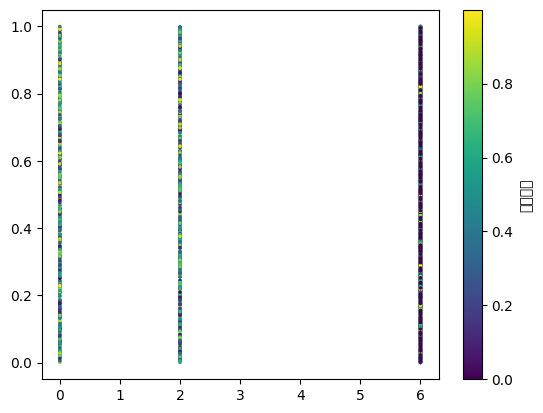

In [ ]:

np.random.seed(0)
num_points = 44180

# x = np.array(top_10_contributions_long["Feature_Index"])
# y = np.array(top_10_contributions_long["Contribution"])

x = [0]*1000+[2]*1000+[6]*42180
y = np.random.rand(num_points) 

sizes = result  # 随机生成0到50之间的数值作为点的颜色依据
# 创建一个散点图，并使用颜色表示数值大小
plt.scatter(x, y, c=list(sizes), cmap='viridis', alpha=1, s = 2)  # 使用'viridis'颜色映射，透明度设置为0.5
# 添加色条图例
plt.colorbar(label='数值大小')  # 设置色条图例的标签为'数值大小'
# 显示图形
plt.show()

# 刪減維度

In [ ]:
top_10_feature = top_10_contributions_df.columns.tolist()
eleminate_h3 = h3_l7_df[['id'] + top_10_feature + ['ohca']]

In [ ]:
train_index=[]
test_index=[]
for i in range(0,eleminate_h3.shape[0]):
    geo_location = h3.h3_to_geo(eleminate_h3.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = eleminate_h3.iloc[train_index]
test_h3_l7_df = eleminate_h3.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = eleminate_h3.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (eleminate_h3.ohca.max()-eleminate_h3.ohca.min()) + eleminate_h3.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

In [ ]:
# 定义XGBoost模型，提前设置early_stopping_rounds
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=10)

# 定義 XGBoost 模型，並設置基本參數與早停條件
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 設置目標函數為平方誤差
    random_state=123456,               # 設定隨機種子以確保結果可重現 42
    early_stopping_rounds=10       # 如果驗證集指標在 10 輪內無改善則提前停止
)

# 定義超參數搜索的候選值範圍
param_dist = {
    'max_depth': [3, 6, 10, 12],          # 樹的最大深度，控制模型的複雜度
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # 每次迭代的步伐大小
    'n_estimators': [50, 100, 200, 300],  # 樹的數量
    'subsample': [0.7, 0.8, 0.9, 1.0],    # 每棵樹隨機採樣的比例
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # 每棵樹使用的特徵比例
    'gamma': [0, 0.1, 0.2, 0.3],          # 控制節點分裂的最小增益
    'reg_alpha': [0, 0.01, 0.1, 1],       # L1 正則化強度
    'reg_lambda': [0, 0.01, 0.1, 1],      # L2 正則化強度
    'min_child_weight': [1, 3, 5],        # 每個葉子節點的最小樣本權重
}

# 使用隨機搜尋進行超參數調整
random_search = RandomizedSearchCV(
    estimator=xgb_model,                 # 基礎模型為 XGBoost
    param_distributions=param_dist,      # 定義超參數搜索空間
    n_iter=100,                          # 搜索 100 次
    cv=5,                                # 使用 5 折交叉驗證
    scoring='neg_mean_absolute_error',   # 評估指標為負的平均絕對誤差
    n_jobs=-1,                           # 使用所有可用 CPU 加速計算
    random_state=42                      # 設定隨機種子以確保結果可重現
)

# 訓練模型並進行超參數搜索
random_search.fit(
    X_train_reguli, y_train_reguli,                    # 訓練數據
    eval_set=[(X_test_reguli, y_test_reguli)],         # 提供測試集進行早停監控
    verbose=True                         # 在訓練過程中輸出詳細信息
)

# 提取經過超參數調整後的最佳模型 (判斷標準MAE)
best_xgb_model = random_search.best_estimator_
# 顯示最佳超參數
print("參數之選擇:", random_search.best_params_)


# # 預測訓練集結果
# y_pred_train = best_xgb_model.predict(X_train)
# # 預測測試集結果
# y_pred_test = best_xgb_model.predict(X_test)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli)*ohca_reguli_inverse
y_train = y_train_reguli*ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli)*ohca_reguli_inverse
y_test = y_test_reguli*ohca_reguli_inverse

[0]	validation_0-rmse:0.25673
[1]	validation_0-rmse:0.24569
[2]	validation_0-rmse:0.23512
[3]	validation_0-rmse:0.22309
[4]	validation_0-rmse:0.21372
[5]	validation_0-rmse:0.20635
[6]	validation_0-rmse:0.19819
[7]	validation_0-rmse:0.19427
[8]	validation_0-rmse:0.19061
[9]	validation_0-rmse:0.18705
[10]	validation_0-rmse:0.18378
[11]	validation_0-rmse:0.18041
[12]	validation_0-rmse:0.17674
[13]	validation_0-rmse:0.17070
[14]	validation_0-rmse:0.16720
[15]	validation_0-rmse:0.16480
[16]	validation_0-rmse:0.16398
[17]	validation_0-rmse:0.16324
[18]	validation_0-rmse:0.16162
[19]	validation_0-rmse:0.15818
[20]	validation_0-rmse:0.15660
[21]	validation_0-rmse:0.15262
[22]	validation_0-rmse:0.15022
[23]	validation_0-rmse:0.14806
[24]	validation_0-rmse:0.14752
[25]	validation_0-rmse:0.14622
[26]	validation_0-rmse:0.14446
[27]	validation_0-rmse:0.14369
[28]	validation_0-rmse:0.14309
[29]	validation_0-rmse:0.14011
[30]	validation_0-rmse:0.13730
[31]	validation_0-rmse:0.13787
[32]	validation_0-

In [ ]:
#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

MAE of train set=  0.6954513606306794
R² of train set=  0.9872362070366183
MAE of test set=  6.075695374861676
R² of test set=  0.7071075464398677


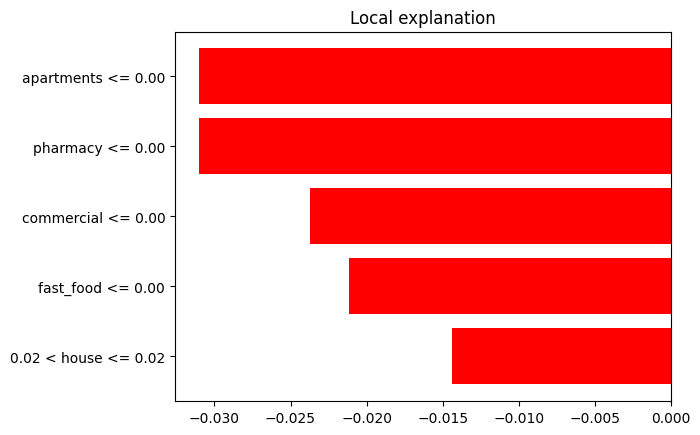

In [ ]:
import lime
import lime.lime_tabular

test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_reguli),
    feature_names=feature_names,
    mode='regression',
    kernel_width=0.75,         # 调整邻近样本的相似性范围
    discretize_continuous=True, # 启用连续特征的离散化
    discretizer='decile',     # 使用四分位数离散化
    random_state=42,            # 设置随机种子
  # 使用Lasso路径进行特征选择
)

# 選擇一個測試樣本進行解釋
idx = 36  # 可以修改 idx 來選擇不同樣本
exp = explainer.explain_instance(X_test_reguli[idx], best_xgb_model.predict, num_features=5)

# 繪製 LIME 解釋圖
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()
plt.show()

In [ ]:
from tqdm import tqdm  # 用於顯示進度條
import re  # 導入正則表達式模組
import seaborn as sns

# 初始化一個空的 DataFrame 來存儲所有樣本的貢獻值
all_contributions = []

# 對每個樣本運行 LIME 並提取貢獻值
for idx in tqdm(range(len(X_test_reguli))):  # 使用 tqdm 顯示進度
    exp = explainer.explain_instance(X_test_reguli[idx], best_xgb_model.predict, num_features=len(feature_names))
    
    # 提取貢獻值
    contributions_relu = exp.as_list()
    contribution_relu_dict = {
    re.sub(r'[^a-zA-Z_]', '', feature): value for feature, value in contributions_relu} # 只保留英文字母和底線

    contribution_dict = {key: value *ohca_reguli_inverse  for key, value in contribution_relu_dict.items()}
    all_contributions.append(contribution_dict)  # 將字典添加到列表中

# 將所有樣本的貢獻值合併為一個 DataFrame
all_contributions_df = pd.DataFrame(all_contributions)

100%|██████████| 94/94 [00:03<00:00, 29.89it/s]


In [ ]:
test_h3_l7_df_chart = test_h3_l7_df.drop('id', axis=1).drop('ohca', axis=1)

from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors

scaler = MinMaxScaler()
test_h3_l7_df_chart[test_h3_l7_df_chart.columns] = scaler.fit_transform(test_h3_l7_df_chart[test_h3_l7_df_chart.columns])

# 將 DataFrame 轉換為長格式，方便繪圖
top_10_contributions_long = top_10_contributions_df.melt(var_name='Feature', value_name='Contribution', ignore_index=False)

# 將 test_h3_l7_df 轉換為長格式
test_h3_l7_long = test_h3_l7_df_chart[top_10_features].melt(var_name='Feature', value_name='H3_L7_Value', ignore_index=False)

# 合併 test_h3_l7_df 的值到貢獻值 DataFrame 中
top_10_contributions_long = top_10_contributions_long.merge(
    test_h3_l7_long,
    on=['Feature'],  # 根據特徵名稱合併
    how='left'
)

# 確保 Feature 軸是類別變數，而非數值
feature_labels = top_10_contributions_long["Feature"].unique()  # 取得所有特徵名稱
feature_mapping = {feature: idx for idx, feature in enumerate(feature_labels)}  # 建立對應關係
top_10_contributions_long["Feature_Index"] = top_10_contributions_long["Feature"].map(feature_mapping)  # 轉換為索引


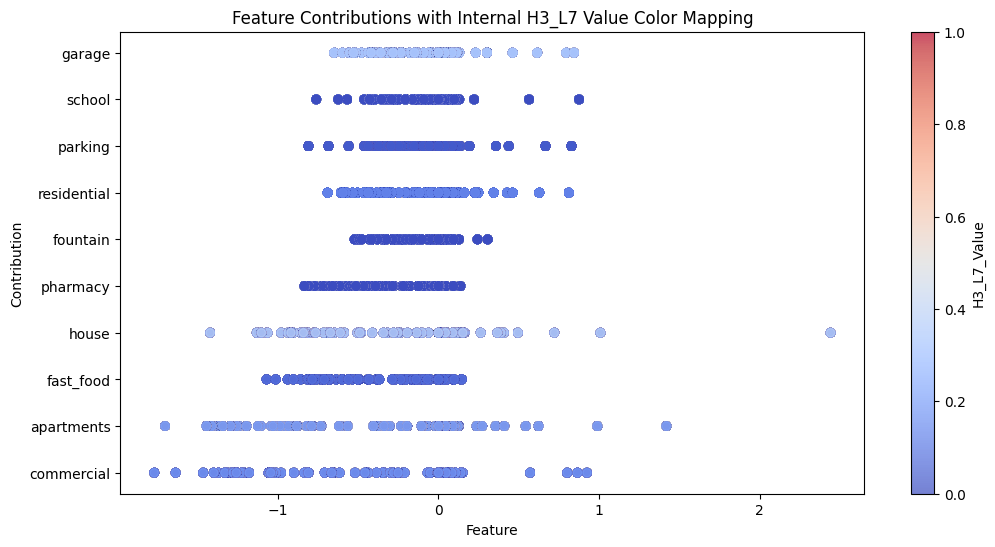

In [ ]:
cmap = plt.get_cmap("coolwarm")  # 由藍到紅

# 繪製散點圖
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    np.array(top_10_contributions_long["Contribution"]),
    np.array(top_10_contributions_long["Feature_Index"]),  # 使用正確的類別索引
    c=np.array(top_10_contributions_long["H3_L7_Value"]),  # 讓顏色由 H3_L7_Value 控制
    cmap=cmap,
    alpha=0.7
)

# 設定 X 軸為 Feature 名稱
plt.yticks(ticks=np.arange(len(feature_labels)), labels=feature_labels)

# 添加顏色條
cbar = plt.colorbar(scatter)
cbar.set_label("H3_L7_Value")

plt.xlabel("Feature")
plt.ylabel("Contribution")
plt.title("Feature Contributions with Internal H3_L7 Value Color Mapping")
plt.show()